In [8]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

Doing work for the preprocessing and looking at how clean the data is

In [2]:
path = r"all_reviews.csv"
path_pq = r"steam_reviews.parquet"

con = duckdb.connect()

df = con.execute(f"""
SELECT *
FROM read_csv_auto('{path}')
LIMIT 4
""").df()

print(df)

con.execute(f"""
DESCRIBE SELECT * FROM read_csv_auto('{path}')
""").fetchall()

   recommendationid  appid            game     author_steamid  \
0         148919893     10  Counter-Strike  76561199036724879   
1         148919350     10  Counter-Strike  76561198826729322   
2         148913051     10  Counter-Strike  76561199101237625   
3         148912714     10  Counter-Strike  76561198347582422   

   author_num_games_owned  author_num_reviews  author_playtime_forever  \
0                       0                   3                      197   
1                       0                  21                      441   
2                       7                   1                     1440   
3                      11                   4                     1636   

   author_playtime_last_two_weeks  author_playtime_at_review  \
0                             197                        197   
1                              37                        441   
2                            1440                       1313   
3                              83              

[('recommendationid', 'BIGINT', 'YES', None, None, None),
 ('appid', 'BIGINT', 'YES', None, None, None),
 ('game', 'VARCHAR', 'YES', None, None, None),
 ('author_steamid', 'BIGINT', 'YES', None, None, None),
 ('author_num_games_owned', 'BIGINT', 'YES', None, None, None),
 ('author_num_reviews', 'BIGINT', 'YES', None, None, None),
 ('author_playtime_forever', 'BIGINT', 'YES', None, None, None),
 ('author_playtime_last_two_weeks', 'BIGINT', 'YES', None, None, None),
 ('author_playtime_at_review', 'BIGINT', 'YES', None, None, None),
 ('author_last_played', 'BIGINT', 'YES', None, None, None),
 ('language', 'VARCHAR', 'YES', None, None, None),
 ('review', 'VARCHAR', 'YES', None, None, None),
 ('timestamp_created', 'BIGINT', 'YES', None, None, None),
 ('timestamp_updated', 'BIGINT', 'YES', None, None, None),
 ('voted_up', 'BIGINT', 'YES', None, None, None),
 ('votes_up', 'BIGINT', 'YES', None, None, None),
 ('votes_funny', 'BIGINT', 'YES', None, None, None),
 ('weighted_vote_score', 'DOUBLE'

In [6]:
sample_df = con.execute(f"""
        SELECT *
        FROM parquet_scan('{path_pq}')
        USING SAMPLE 0.5%
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [11]:
print(con.execute("""
SELECT voted_up, COUNT(*) 
FROM parquet_scan(?)
GROUP BY voted_up
""", [path_pq]).df())



   voted_up  count_star()
0      True      97470855
1     False      16412862


In [17]:
pos = 97470855
neg = 16412862
print(f"pct of positive reviews = {round((pos / (pos + neg)), 4)}")

pct of positive reviews = 0.8559


Looking at the variable that shows whether someone left a review with an upvote or downvote it seems that there were many more positive reviews than negative with there being 86% positive reviews in the data set. This makes sense as people are much more likely to go in and leave a positive review for a game they like than someone is who didn't like it as people who don't like it will probably just stop playing. Only people who really hated the game or had major issues usually leave a negative review. This is important though to think about as this is unbalanced data so need to account for this. Some ideas for what to do when doing the analysis is going month by month and looking at games specifically that release with a lot of negative reviews or have spikes of negative reviews to see how the games respond to this.

In [19]:
df_time_check = con.execute("""
SELECT 
    MIN(timestamp_created) AS min_time,
    MAX(timestamp_created) AS max_time
FROM parquet_scan(?)
""", [path_pq]).df()

print(df_time_check)

                   min_time                  max_time
0 2010-10-15 15:24:52-07:00 2023-11-03 09:16:25-07:00


The timeframe of the data set seems really good as it has data from 2010 until 2023.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

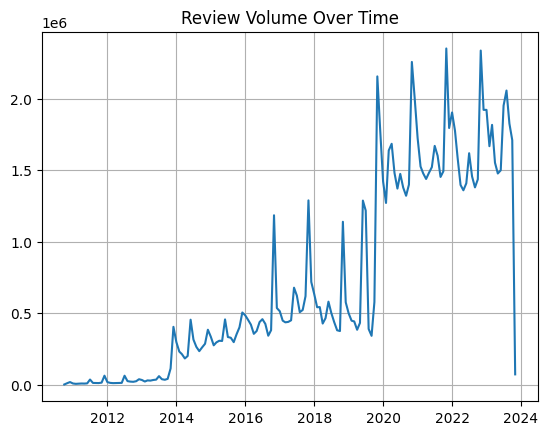

In [23]:
df_reviews_time = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    COUNT(*) AS review_count
FROM parquet_scan(?)
GROUP BY month
ORDER BY month
""", [path_pq]).df()

plt.plot(df_reviews_time["month"], df_reviews_time["review_count"])
plt.title("Review Volume Over Time")
plt.grid(True)
plt.show()

Review volume looks accurate with increasing steady over time until a huge spike when covid started as this makes sense since a ton of people started playing video games in this time. There is a sudden drop at the end of the data set which is a little weird so might want to cut off right before then.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

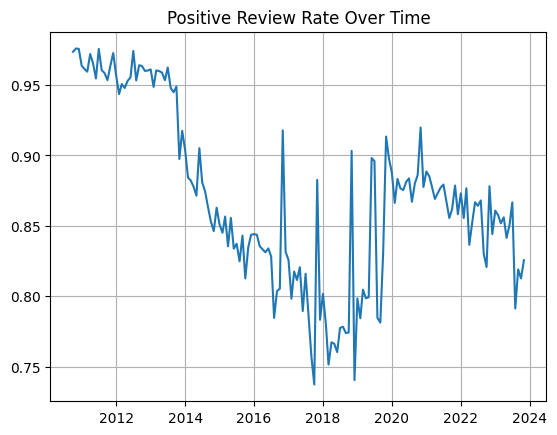

In [24]:
df_sentiment_time = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(voted_up AS INT)) AS positive_rate
FROM parquet_scan(?)
GROUP BY month
ORDER BY month
""", [path_pq]).df()

plt.plot(df_sentiment_time["month"], df_sentiment_time["positive_rate"])
plt.title("Positive Review Rate Over Time")
plt.grid(True)
plt.show()

This graph makes a lot of sense as at the start of the data set the volume of reviews was much lower than later years so it was mostly just people who were big fans of games giving reviews until gaming became more mainstreamed later on which is why the positive review rate drops over time but stabilizes after review volume also stabilized.

In [25]:
null_check = con.execute("""
SELECT 
    COUNT(*) AS total_rows,
    SUM(timestamp_created IS NULL) AS null_timestamps,
    SUM(voted_up IS NULL) AS null_sentiment,
    SUM(appid IS NULL) AS null_appid
FROM parquet_scan(?)
""", [path_pq]).df()

print(null_check)

   total_rows  null_timestamps  null_sentiment  null_appid
0   113883717              0.0             0.0         0.0


This is great because we do not have any null values in our most important values so we do not have to deal with any decisions regarding null values.

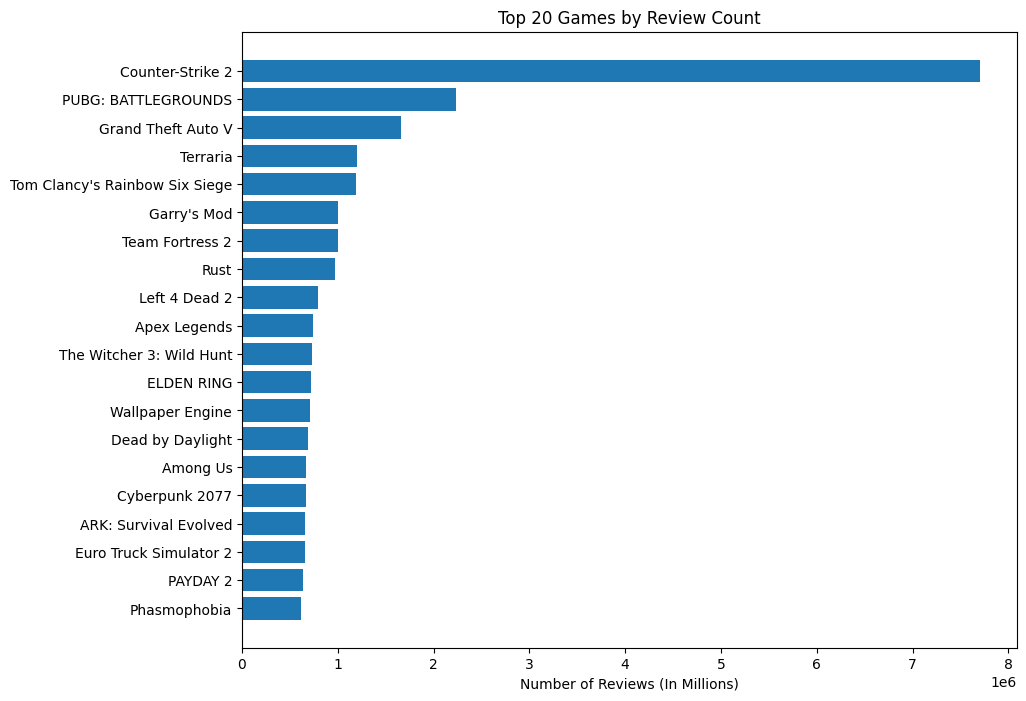

In [31]:
top_games = con.execute("""
    SELECT game, COUNT(*) AS total_reviews
    FROM parquet_scan(?)
    GROUP BY game
    ORDER BY total_reviews DESC
    LIMIT 20
    """,
    [path_pq]).df()

plt.figure(figsize=(10, 8))
plt.barh(top_games["game"], top_games["total_reviews"])
plt.xlabel("Number of Reviews (In Millions)")
plt.title("Top 20 Games by Review Count")
plt.gca().invert_yaxis()
plt.show()


The dataset is highly imbalanced across games, with a small number of popular titles (Counter-Strike 2, PUBG, and Grand Theft Auto V) contributing millions of reviews each. This dominance suggests that aggregated sentiment trends over time may primarily reflect the review patterns of a few high-engagement games rather than the broader Steam ecosystem. As a result, analyzing sentiment at the individual game level may provide more accurate insights into developer responsiveness and sentiment evolution.

In [38]:
sample_df["author_playtime_forever"].describe()

count    5.233220e+05
mean     1.878477e+04
std      4.842350e+04
min      0.000000e+00
25%      8.070000e+02
50%      3.297000e+03
75%      1.398400e+04
max      3.226958e+06
Name: author_playtime_forever, dtype: float64

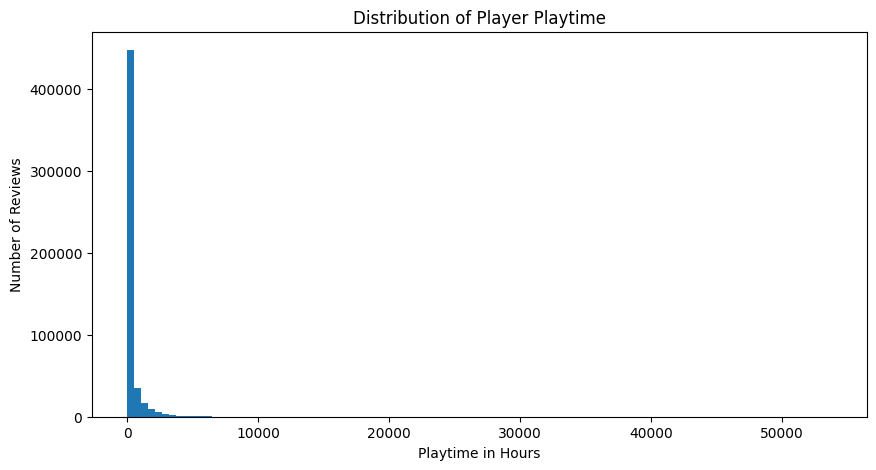

In [41]:
playtime_hours = sample_df["author_playtime_forever"] / 60

plt.figure(figsize=(10,5))
plt.hist(playtime_hours, bins=100)
plt.xlabel("Playtime in Hours")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Player Playtime")
plt.show()

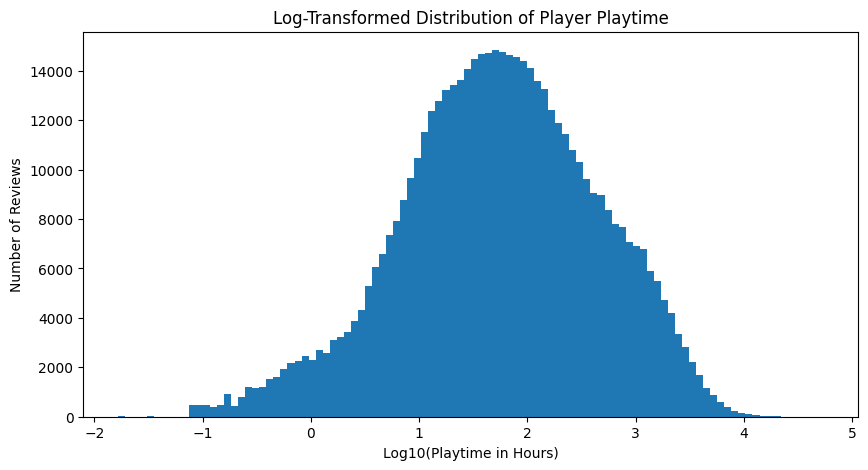

In [42]:
playtime_hours = sample_df["author_playtime_forever"] / 60
playtime_hours = playtime_hours[playtime_hours > 0]
log_playtime = np.log10(playtime_hours)

plt.figure(figsize=(10, 5))
plt.hist(log_playtime, bins=100)
plt.xlabel("Log10(Playtime in Hours)")
plt.ylabel("Number of Reviews")
plt.title("Log-Transformed Distribution of Player Playtime")
plt.show()

The distribution from the random sample of the dataset is of player playtime which is extremely right skewed with a heavy tail and a large number of near zero values. This makes sense as on average people play games casually but some people have extremely high video game playtime hours like people who are just addicted or those who have made a career out of video games. Also, some people "afk" in a game which is where you leave the game on for some reason that depends on what the game is so these people would have extremely high game playtime hours as even though they aren't actually playing steam records these users as still playing.

In [43]:
(sample_df["author_playtime_forever"] == 0).mean()

np.float64(0.006561925544884412)

Just did this to check if there were a large amount of reviews with people that had 0 playtime minutes but this is a very small percent (< 1%) so this isn't concerning for the analysis.